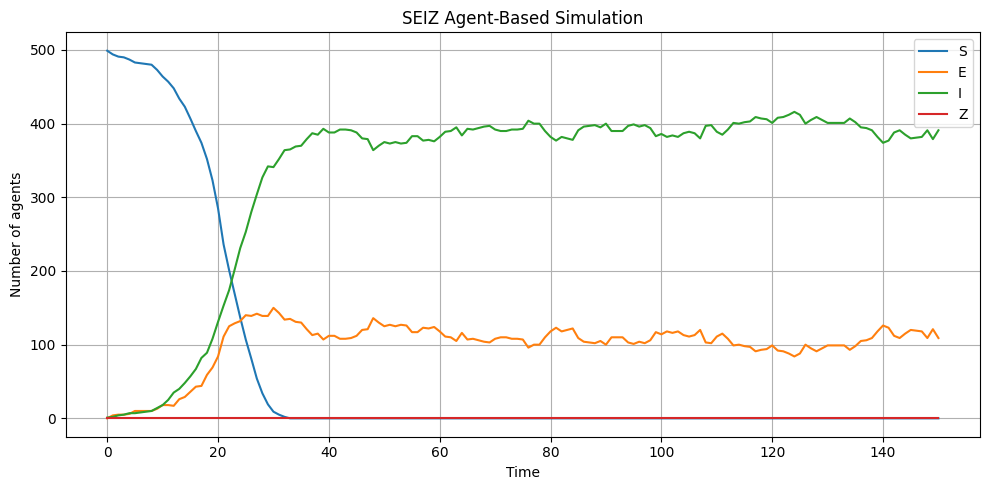

Final state counts: Counter({'I': 391, 'E': 109})


In [2]:
"""
Agent-based SEIZ model on a social network (NetworkX-based)

States:
  S - Susceptible
  E - Exposed
  I - Infected (spreader)
  Z - Skeptic

Parameters (match Table 1 in SEIZ definition):
  beta : contact rate between S and I
  b    : contact rate between S and Z
  rho  : contact rate (transition rate) E -> I
  eps  : rate I -> E
  p    : probability S -> I after contact with I
  l    : probability S -> Z after contact with Z
"""

import random
import math
from collections import Counter, defaultdict
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


def rate_to_prob(rate, dt):
    """Convert a continuous-time rate to per-timestep probability."""
    return 1 - math.exp(-rate * dt)


def simulate_seiz_abm(
    G,
    params,
    initial_states=None,
    steps=100,
    dt=1.0,
    seed=None,
    record=True,
):
    """
    Simulate the SEIZ epidemic model on a given social network.

    Args:
        G: networkx Graph (nodes = agents)
        params: dict with keys
            beta, b, rho, eps, p, l
        initial_states: dict node->state (S, E, I, Z). If None, start with all S except one I.
        steps: number of discrete timesteps
        dt: timestep size (used to convert rates to per-step probabilities)
        seed: random seed
        record: whether to return time series counts

    Returns:
        history: dict of time series (if record=True)
        states: final dict node->state
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Extract parameters
    beta = float(params["beta"])   # S-I contact rate
    b = float(params["b"])         # S-Z contact rate
    rho = float(params["rho"])     # E -> I transition rate
    eps = float(params["eps"])     # I -> E transition rate
    p = float(params["p"])         # S->I after contact with I
    l = float(params["l"])         # S->Z after contact with Z

    # Convert rates to per-step probabilities
    prob_contact_I = rate_to_prob(beta, dt)
    prob_contact_Z = rate_to_prob(b, dt)
    prob_E_to_I = rate_to_prob(rho, dt)
    prob_I_to_E = rate_to_prob(eps, dt)

    # Initialize states
    states = {}
    nodes = list(G.nodes())
    if initial_states is None:
        for n in nodes:
            states[n] = "S"
        if nodes:
            patient_zero = random.choice(nodes)
            states[patient_zero] = "I"
    else:
        for n in nodes:
            states[n] = initial_states.get(n, "S")

    # For recording time series
    history = {"t": [], "S": [], "E": [], "I": [], "Z": []} if record else None

    for step in range(steps):
        if record:
            counts = Counter(states.values())
            history["t"].append(step * dt)
            for s in ("S", "E", "I", "Z"):
                history[s].append(counts.get(s, 0))

        proposals = defaultdict(list)

        # --- Contact-based transitions ---
        for node, state in states.items():
            # Infectious contacts (S-I)
            if state == "I":
                for nbr in G.neighbors(node):
                    if states[nbr] == "S" and random.random() < prob_contact_I:
                        if random.random() < p:
                            proposals[nbr].append("I")
                        else:
                            proposals[nbr].append("E")

            # Skeptic contacts (S-Z)
            elif state == "Z":
                for nbr in G.neighbors(node):
                    if states[nbr] == "S" and random.random() < prob_contact_Z:
                        if random.random() < l:
                            proposals[nbr].append("Z")
                        else:
                            proposals[nbr].append("E")

        # --- Internal progressions (E <-> I) ---
        for node, state in states.items():
            if state == "E" and random.random() < prob_E_to_I:
                proposals[node].append("I")
            elif state == "I" and random.random() < prob_I_to_E:
                proposals[node].append("E")

        # --- Apply updates synchronously ---
        new_states = dict(states)
        for node, plist in proposals.items():
            chosen = random.choice(plist)
            new_states[node] = chosen

        states = new_states

    # Record final step
    if record:
        counts = Counter(states.values())
        history["t"].append(steps * dt)
        for s in ("S", "E", "I", "Z"):
            history[s].append(counts.get(s, 0))

    return history, states


def plot_history(history, title="SEIZ Agent-Based Simulation"):
    """Plot time series of state counts."""
    t = history["t"]
    plt.figure(figsize=(10, 5))
    for s in ("S", "E", "I", "Z"):
        plt.plot(t, history[s], label=s)
    plt.xlabel("Time")
    plt.ylabel("Number of agents")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    # Network example
    N = 500
    G = nx.watts_strogatz_graph(n=N, k=6, p=0.1, seed=42)

    params = {
        "beta": 0.6,   # contact rate S-I
        "b": 0.3,      # contact rate S-Z
        "rho": 0.2,    # E -> I rate
        "eps": 0.05,   # I -> E rate
        "p": 0.4,      # probability S->I after contact with I
        "l": 0.6,      # probability S->Z after contact with Z
    }

    history, final_states = simulate_seiz_abm(G, params, steps=150, dt=1.0, seed=123)
    plot_history(history)
    print("Final state counts:", Counter(final_states.values()))


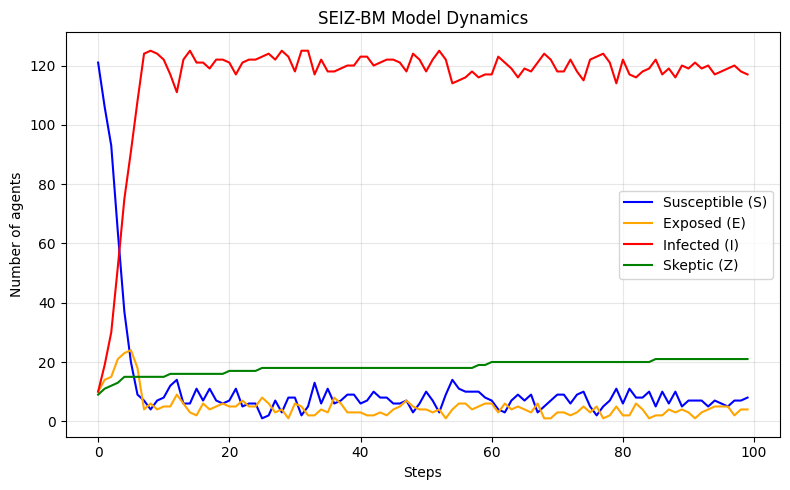

In [6]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation


class Agent:
    def __init__(self, state="S"):
        self.state = state  # S, E, I, or Z


class SEIZBMModel:
    def __init__(self, graph, beta, b, rho, p, epsilon, l, mu, m):
        """
        SEIZ-BM agent-based model (with Basic Moderator).

        Parameters
        ----------
        graph : networkx.Graph
            Social network of agents.
        beta : float
            Contact rate between S and I.
        b : float
            Contact rate between S and Z.
        rho : float
            Contact rate between E and I.
        p : float
            Probability that S becomes I after contact with I.
        epsilon : float
            Incubation rate (E -> I).
        l : float
            Probability that S becomes Z after contact with Z.
        mu : float
            Rate of moderator intervention (probability that an I is moderated).
        m : float
            Probability that a moderated I returns to S.
        """
        self.graph = graph
        self.beta = beta
        self.b = b
        self.rho = rho
        self.p = p
        self.epsilon = epsilon
        self.l = l
        self.mu = mu
        self.m = m

        for n in self.graph.nodes():
            self.graph.nodes[n]['agent'] = Agent("S")

    def initialize_states(self, infected_frac=0.05, skeptic_frac=0.05):
        nodes = list(self.graph.nodes())
        random.shuffle(nodes)
        n = len(nodes)

        infected = nodes[:int(n * infected_frac)]
        skeptics = nodes[int(n * infected_frac):int(n * (infected_frac + skeptic_frac))]

        for i in infected:
            self.graph.nodes[i]['agent'].state = "I"
        for z in skeptics:
            self.graph.nodes[z]['agent'].state = "Z"

    def step(self):
        new_states = {}
        for node in self.graph.nodes():
            agent = self.graph.nodes[node]['agent']
            state = agent.state

            if state == "S":
                neighbors = self.graph.neighbors(node)
                for nb in neighbors:
                    nb_state = self.graph.nodes[nb]['agent'].state
                    if nb_state == "I" and random.random() < self.beta:
                        new_states[node] = "I" if random.random() < self.p else "E"
                        break
                    elif nb_state == "Z" and random.random() < self.b:
                        new_states[node] = "Z" if random.random() < self.l else "E"
                        break

            elif state == "E":
                if random.random() < self.epsilon:
                    new_states[node] = "I"
                else:
                    neighbors = self.graph.neighbors(node)
                    for nb in neighbors:
                        if self.graph.nodes[nb]['agent'].state == "I" and random.random() < self.rho:
                            new_states[node] = "I"
                            break

            elif state == "I":
                if random.random() < self.mu:  # Moderator intervenes
                    if random.random() < self.m:
                        new_states[node] = "S"
                    else:
                        new_states[node] = "I"

        for node, new_state in new_states.items():
            self.graph.nodes[node]['agent'].state = new_state

    def count_states(self):
        counts = {"S": 0, "E": 0, "I": 0, "Z": 0}
        for node in self.graph.nodes():
            counts[self.graph.nodes[node]['agent'].state] += 1
        return counts

    def run(self, steps=50):
        history = []
        for _ in range(steps):
            self.step()
            history.append(self.count_states())
        return history

    def plot_time_series(self, history):
        steps = range(len(history))
        s = [h["S"] for h in history]
        e = [h["E"] for h in history]
        i = [h["I"] for h in history]
        z = [h["Z"] for h in history]

        plt.figure(figsize=(8, 5))
        plt.plot(steps, s, label="Susceptible (S)", color="blue")
        plt.plot(steps, e, label="Exposed (E)", color="orange")
        plt.plot(steps, i, label="Infected (I)", color="red")
        plt.plot(steps, z, label="Skeptic (Z)", color="green")
        plt.xlabel("Steps")
        plt.ylabel("Number of agents")
        plt.title("SEIZ-BM Model Dynamics")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    def animate_network(self, steps=50, interval=500):
        pos = nx.spring_layout(self.graph, seed=42)
        fig, ax = plt.subplots(figsize=(6, 6))

        def update(frame):
            ax.clear()
            self.step()
            colors = []
            for node in self.graph.nodes():
                state = self.graph.nodes[node]['agent'].state
                if state == "S":
                    colors.append("blue")
                elif state == "E":
                    colors.append("orange")
                elif state == "I":
                    colors.append("red")
                elif state == "Z":
                    colors.append("green")

            nx.draw(self.graph, pos, node_color=colors, with_labels=False, node_size=100, ax=ax)
            ax.set_title(f"Step {frame}")

        ani = animation.FuncAnimation(fig, update, frames=steps, interval=interval, repeat=False)
        plt.show()


if __name__ == "__main__":
    # Create a social network (Erdős–Rényi example)
    G = nx.erdos_renyi_graph(150, 0.04)

    model = SEIZBMModel(
        G,
        beta=0.3,   # S-I contact rate
        b=0.1,      # S-Z contact rate
        rho=0.2,    # E-I contact rate
        p=0.5,      # probability S->I after I contact
        epsilon=0.2,# incubation rate E->I
        l=0.3,      # probability S->Z after Z contact
        mu=0.1,     # moderator intervention rate
        m=0.5       # probability of successful moderation
    )

    model.initialize_states()
    history = model.run(steps=100)
    model.plot_time_series(history)

    # Uncomment to visualize network dynamics
    #model.animate_network(steps=40, interval=400)


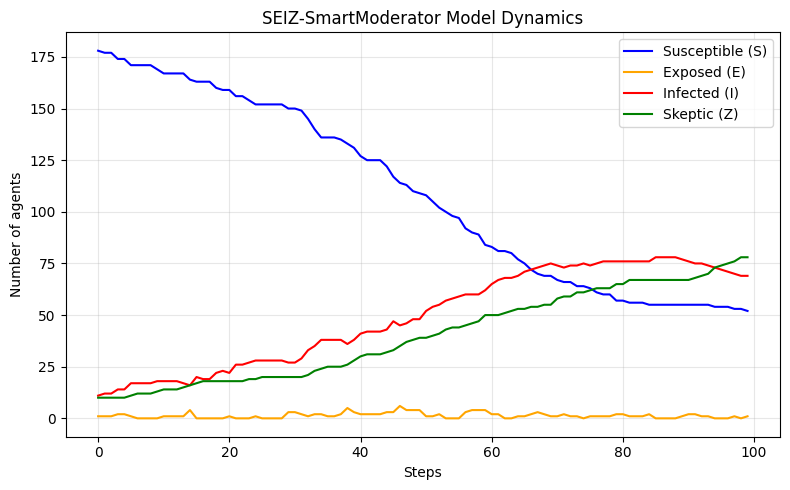

In [7]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict


class Agent:
    def __init__(self, state="S"):
        self.state = state  # S, E, I, or Z
        # Dark Triad profile: [Narcissism, Machiavellianism, Psychopathy]
        self.profile = [random.random(), random.random(), random.random()]
        self.toxic_messages = 0  # count of toxic messages sent
        self.activity_level = 0  # number of messages sent overall


class SEIZSmartModeratorModel:
    def __init__(self, graph, beta, b, rho, p, epsilon, l, n, theta, T, eta, lambd):
        """
        SEIZ-SM (Smart Moderator) Agent-Based Model

        Parameters
        ----------
        graph : networkx.Graph
            Social network of agents.
        beta : float
            Contact rate S-I.
        b : float
            Contact rate S-Z.
        rho : float
            Contact rate E-I.
        p : float
            Probability that S becomes I after contact with I.
        epsilon : float
            Incubation rate (E -> I).
        l : float
            Probability that S becomes Z after contact with Z.
        n : int
            Number of messages sent at each timestep.
        theta : int
            Toxic message threshold for moderator intervention.
        T : float
            Probability threshold to classify a message as toxic.
        eta : float
            Probability of reverting from I -> E after moderation.
        lambd : float
            Probability of E -> Z transition after moderation or exposure.
        """
        self.graph = graph
        self.beta = beta
        self.b = b
        self.rho = rho
        self.p = p
        self.epsilon = epsilon
        self.l = l
        self.n = n
        self.theta = theta
        self.T = T
        self.eta = eta
        self.lambd = lambd

        for node in self.graph.nodes():
            self.graph.nodes[node]["agent"] = Agent("S")

    def initialize_states(self, infected_frac=0.05, skeptic_frac=0.05):
        nodes = list(self.graph.nodes())
        random.shuffle(nodes)
        n = len(nodes)
        infected = nodes[: int(n * infected_frac)]
        skeptics = nodes[int(n * infected_frac) : int(n * (infected_frac + skeptic_frac))]
        for i in infected:
            self.graph.nodes[i]["agent"].state = "I"
        for z in skeptics:
            self.graph.nodes[z]["agent"].state = "Z"

    def compute_toxicity(self, agent):
        """Compute toxicity score based on Dark Triad profile."""
        return sum(agent.profile) / 3.0

    def moderator_intervention(self, agent):
        """Smart moderator intervenes if threshold exceeded."""
        if agent.toxic_messages >= self.theta:
            # Probability of becoming exposed depends on Dark Triad traits
            dark_trait_factor = 1 - sum(agent.profile) / 3.0
            effective_eta = self.eta * dark_trait_factor
            if random.random() < effective_eta:
                agent.state = "E"
                agent.toxic_messages = 0  # reset counter
            elif random.random() < self.lambd:
                agent.state = "Z"
                agent.toxic_messages = 0

    def send_messages(self):
        """Simulate message sending process with toxicity."""
        senders = random.sample(list(self.graph.nodes()), min(self.n, len(self.graph)))
        toxic_senders = []
        for sender in senders:
            agent = self.graph.nodes[sender]["agent"]
            agent.activity_level += 1
            if agent.state == "I":
                tox = self.compute_toxicity(agent)
                if tox >= self.T:
                    agent.toxic_messages += 1
                    toxic_senders.append(sender)
                    self.moderator_intervention(agent)
        return toxic_senders

    def spread_toxicity(self, toxic_senders):
        """Neighbors of toxic senders may transition based on SEIZ logic."""
        for sender in toxic_senders:
            neighbors = self.graph.neighbors(sender)
            for nb in neighbors:
                nb_agent = self.graph.nodes[nb]["agent"]
                if nb_agent.state == "S":
                    if random.random() < self.beta:
                        nb_agent.state = "I" if random.random() < self.p else "E"
                elif nb_agent.state == "E":
                    if random.random() < self.rho:
                        nb_agent.state = "I"

    def internal_transitions(self):
        """Handle E -> I and E -> Z transitions."""
        for node in self.graph.nodes():
            agent = self.graph.nodes[node]["agent"]
            if agent.state == "E":
                if random.random() < self.epsilon:
                    agent.state = "I"
                elif random.random() < self.lambd:
                    agent.state = "Z"

    def step(self):
        toxic_senders = self.send_messages()
        self.spread_toxicity(toxic_senders)
        self.internal_transitions()

    def count_states(self):
        counts = defaultdict(int)
        for node in self.graph.nodes():
            counts[self.graph.nodes[node]["agent"].state] += 1
        return counts

    def run(self, steps=50):
        history = []
        for _ in range(steps):
            self.step()
            history.append(self.count_states())
        return history

    def plot_time_series(self, history):
        steps = range(len(history))
        s = [h["S"] for h in history]
        e = [h["E"] for h in history]
        i = [h["I"] for h in history]
        z = [h["Z"] for h in history]

        plt.figure(figsize=(8, 5))
        plt.plot(steps, s, label="Susceptible (S)", color="blue")
        plt.plot(steps, e, label="Exposed (E)", color="orange")
        plt.plot(steps, i, label="Infected (I)", color="red")
        plt.plot(steps, z, label="Skeptic (Z)", color="green")
        plt.xlabel("Steps")
        plt.ylabel("Number of agents")
        plt.title("SEIZ-SmartModerator Model Dynamics")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    # Example network
    G = nx.erdos_renyi_graph(200, 0.03, seed=42)

    model = SEIZSmartModeratorModel(
        G,
        beta=0.3,   # S-I contact rate
        b=0.1,      # S-Z contact rate
        rho=0.2,    # E-I contact rate
        p=0.5,      # probability S->I
        epsilon=0.2,# incubation rate
        l=0.3,      # probability S->Z
        n=30,       # number of messages per timestep
        theta=3,    # toxic message threshold for intervention
        T=0.5,      # toxicity threshold
        eta=0.5,    # probability I->E after moderation
        lambd=0.2   # probability E->Z
    )

    model.initialize_states()
    history = model.run(steps=100)
    model.plot_time_series(history)
